# Introduction to Data Science 
# Lecture 11: Linear Regression 2
* Adapted from COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecutre, we'll discuss:
* overfitting, model generalizability, and the bias-variance tradeoff
* cross validation 
* using categorical variables for regression 

Recommended reading:
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 3 [digitial version available here](http://www-bcf.usc.edu/~gareth/ISL/)


## Review from the last lecture

### Simple Linear Regression (SLR)

** Data**: We have $n$ samples $(x, y)_i$, $i=1,\ldots n$. 

** Model**: $y \sim \beta_0 + \beta_1 x$ 

**Goal**: Find the best values of $\beta_0$ and $\beta_1$, denoted $\hat{\beta}_0$ and $\hat{\beta}_1$, so that the prediction $y = \hat{\beta}_0 + \hat{\beta}_1 x$ "best fits" the data. 

<img src="438px-Linear_regression.png", title="https://en.wikipedia.org/wiki/Linear_regression", width="40%">

**Theorem.** 
The parameters that minimize the "residual sum of squares (RSS)", 
$RSS = \sum_i (y_i - \beta_0 - \beta_1 x_i)^2$, 
are: 
$$
\hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y}) }{\sum_{i=1}^n (x_i - \overline{x})^2}
\qquad \textrm{and} \qquad
\hat{\beta}_0 = \overline{y} -  \hat{\beta}_1 \overline{x}. 
$$
where $\overline{x} = \frac{1}{n} \sum_{i=1}^n x_i$ and $\overline{y} = \frac{1}{n} \sum_{i=1}^n y_i$. 


### Multilinear regression 

** Data**: We have $n$ samples of the form $\big(x_1, x_2 , \ldots, x_m , y \big)_i$, $i=1,\ldots n$. 

** Model**: $y \sim \beta_0 + \beta_1 x_1 + \cdots \beta_m x_m $ 

### Nonlinear relationships  

** Data**: We have $n$ samples $\big(x_1, x_2 , \ldots, x_m , y \big)_i$, $i=1,\ldots n$. 

** Model**: $y \sim \beta_0 + \beta_1 f_1(x_1,x_2,\ldots,x_m) + \cdots \beta_k f_k(x_1,x_2,\ldots,x_m)$ 


## Regression with python

There are several different python packages that do regression:
1. [statsmodels](http://statsmodels.sourceforge.net/)
+ [scikit-learn](http://scikit-learn.org/)
+ [SciPy](http://www.scipy.org/)
+ ... 

Last time, I commented that statsmodels approaches regression from a statistics viewpoint, while scikit-learn approaches from a machine learning viewpoint. I'll say more about this today. 

SciPy has some regression tools, but compared to these other two packages, they are relatively limited. 


In [36]:
# imports and setup

import scipy as sc
import numpy as np

import pandas as pd
import statsmodels.formula.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Advertisement dataset
Consider the 'Advertising' dataset from
[here](http://www-bcf.usc.edu/~gareth/ISL/data.html).


For 200 different ‘markets’ (think different cities), this dataset consists of the number of sales of a particular product as well as the advertising budget for three different media: TV, radio, and newspaper. 



Last time, after trying a variety of linear models, we discovered the following one, which includes a nonlinear relationship between the TV budget and Radio budget:
$$
\text{Sales} = \beta_0 + \beta_1 * \text{TVBudget} + \beta_2*\text{RadioBudget} + \beta_3 * \text{TVBudget} *\text{RadioBudget}. 
$$

In [37]:
advert = pd.read_csv('Advertising.csv',index_col=0) #load data

ad_NL = sm.ols(formula="Sales ~ TV + Radio + TV*Radio", data=advert).fit()
ad_NL.summary()

FileNotFoundError: [Errno 2] No such file or directory: 'Advertising.csv'

This model is really excellent: 
- $R^2 = 97\%$ of the variability in the data is accounted for by the model. 
- The $p$-value for the F-statistic is very small 
- The $p$-values for the individual coefficients are small 

Interpretation: 
- In a particular market, if I spend an additional $1k on TV advertising, what do I expect sales to do? 
- Should I spend additional money on TV or Radio advertising? 

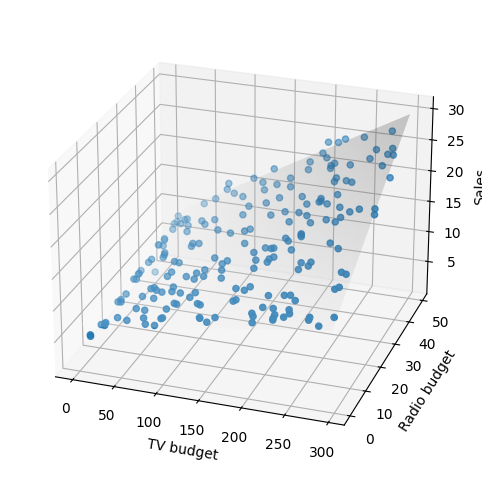

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=advert['TV'], ys=advert['Radio'], zs=advert['Sales'])

x = np.linspace(advert['TV'].min(), advert['TV'].max(), 100)
y = np.linspace(advert['Radio'].min(), advert['Radio'].max(), 100)
X,Y = np.meshgrid(x,y)
par = dict(ad_NL.params)
Z = par["Intercept"] + par["TV"]*X + par["Radio"]*Y + par["TV:Radio"]*X*Y
surf = ax.plot_surface(X, Y, Z,cmap=cm.Greys, alpha=0.2)

ax.view_init(25,-71)

ax.set_xlabel('TV budget')
ax.set_ylabel('Radio budget')
ax.set_zlabel('Sales')

plt.show()

### A word of caution on overfitting

It is tempting to include a lot of terms in the regression, but this is problematic (think $p$-hacking.) A useful model will  *generalize* beyond the data given to it. 


**Questions?**

## Overfitting, underfitting, model generalizability, and the bias–variance tradeoff

In regression, and other prediction problems, we would like to develop a model on a dataset, that would preform well, not only on that dataset, but on similar data that the model hasn't yet seen by the model. If a model satisfies this criterion, we would that it is *generalizable*. 

Consider the following data, that has been fit with a linear polynomial model (black) and a high degree polynomial model (blue). For convenience, let me call these the black and blue models, respectively. 

![Overfit data](https://upload.wikimedia.org/wikipedia/commons/6/68/Overfitted_Data.png)


Let's call the dataset that we train the model on the *training dataset* and the dataset that we test the model on the *testing dataset*. In the above figure, the training dataset are the black points and the testing dataset is not shown, but we imagine it to be similiar to the points shown. 

Which model is better? 

The blue model has 100% accuracy on the training dataset, while the black model has much smaller accuracy. However, the blue model is highly oscillatory and might not generalize well to new data. For example, the model would wildly miss the test point $(3,0)$. We say that the blue model has *overfit* the data. On the other hand, it isn't difficult to see that we could also *underfit* the data. In this case, the model isn't complex enough to have good accuracy on the training dataset. 

This phenomena is often described in terms of the *bias-variance tradeoff*. Here, we decompose the error of the model into three terms:
$$
\textrm{Error} = 
\textrm{Bias} + 
\textrm{Variance} + 
\textrm{Irreducible Error}. 
$$
- The *bias* of the method is the error caused by the simplifying assumptions built into the method. 
+ The *variance* of the method is how much the model will change based on the sampled data. 
+ The *irreducible error* is error in the data itself, so no model can capture this error. 

There is a tradeoff between the bias and variance of a model. 
High-variance methods (e.g., the blue method) are accurate on the training set, but overfit noise in the data, so don't generalized well to new data. High-bias models (e.g., the black method) are too simple to fit the data, but are better at generalizing to new test data. 


## Generalizability in practice

Consider the Auto dataset, which contains 9 features (mpg, cylinders, displacement, horsepower, weight, acceleration, year, origin, name) for 397 different used cars. This dataset is available digitally here: [link](http://www-bcf.usc.edu/~gareth/ISL/)

In [ ]:
auto = pd.read_csv('Auto.csv') #load data

#display(auto.dtypes)

# one of the horsepowers is '?', so we just remove it and then map the remaining strings to integers
auto = auto[auto.horsepower != '?']
auto['horsepower'] = auto['horsepower'].map(int)

auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [ ]:
print(auto.describe())

              mpg   cylinders  displacement  horsepower       weight  \
count  392.000000  392.000000    392.000000  392.000000   392.000000   
mean    23.445918    5.471939    194.411990  104.469388  2977.584184   
std      7.805007    1.705783    104.644004   38.491160   849.402560   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.000000    4.000000    105.000000   75.000000  2225.250000   
50%     22.750000    4.000000    151.000000   93.500000  2803.500000   
75%     29.000000    8.000000    275.750000  126.000000  3614.750000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration        year      origin  
count    392.000000  392.000000  392.000000  
mean      15.541327   75.979592    1.576531  
std        2.758864    3.683737    0.805518  
min        8.000000   70.000000    1.000000  
25%       13.775000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.025000   79.0000

Let's consider the relationship between mpg and horsepower

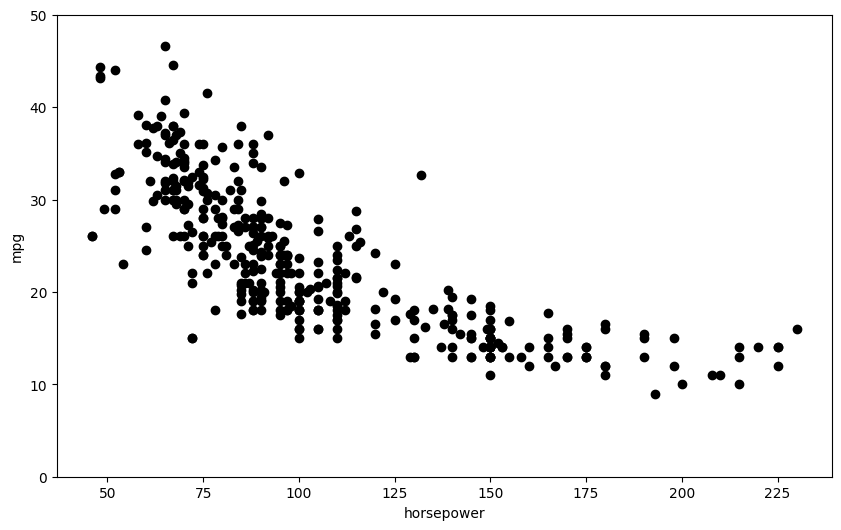

In [ ]:
plt.scatter(auto['horsepower'],auto['mpg'],color='black',linewidth=1)
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()

We consider the linear model
$$
\text{mpg} = \beta_0 + \beta_1 \text{horsepower} + \beta_2 \text{horsepower}^2 + \cdots + \beta_m \text{horsepower}^m
$$
It might seem that choosing $m$ to be large would be a good thing. After all, a high degree polynomial is more flexible than a small degree polynomial. 

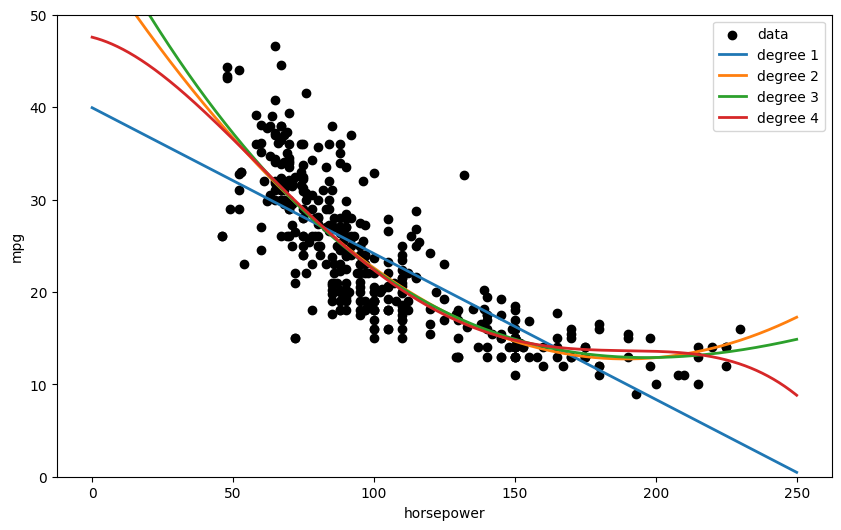

In [ ]:
# fit polynomial models
mr1 = sm.ols(formula="mpg ~ horsepower", data=auto).fit()
par1 = dict(mr1.params)
mr2 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** 2.0)", data=auto).fit()
par2 = dict(mr2.params)
mr3 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** 2.0) + I(horsepower ** 3.0)", data=auto).fit()
par3 = dict(mr3.params)
mr4 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** 2.0) + I(horsepower ** 3.0) + I(horsepower ** 4.0)", data=auto).fit()
par4 = dict(mr4.params)

plt.scatter(auto['horsepower'],auto['mpg'],color='black',label="data")

x = np.linspace(0,250,1000)
y1 = par1["Intercept"] + par1['horsepower']*x
y2 = par2["Intercept"] + par2['horsepower']*x + par2['I(horsepower ** 2.0)']*x**2
y3 = par3["Intercept"] + par3['horsepower']*x + par3['I(horsepower ** 2.0)']*x**2 + par3['I(horsepower ** 3.0)']*x**3
y4 = par4["Intercept"] + par4['horsepower']*x + par4['I(horsepower ** 2.0)']*x**2 + par4['I(horsepower ** 3.0)']*x**3 + par4['I(horsepower ** 4.0)']*x**4

plt.plot(x,y1,label="degree 1",linewidth=2)
plt.plot(x,y2,label="degree 2",linewidth=2)
plt.plot(x,y3,label="degree 3",linewidth=2)
plt.plot(x,y4,label="degree 4",linewidth=2)
plt.legend()
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()

In [ ]:
print('mr1:',mr1.rsquared)
print('mr2:',mr2.rsquared)
print('mr3:',mr3.rsquared)
print('mr4:',mr4.rsquared)

mr1: 0.6059482578894348
mr2: 0.6875590305127516
mr3: 0.68821369312591
mr4: 0.6893436054929452


As $m$ increases, the $R^2$ value is becoming larger. (You can prove that this is always true if you add more predictors.)

Let's check the $p$-values for the coefficients for the degree 4 fit.

In [ ]:
display(mr4.summary())
display(mr2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     214.7
Date:                Tue, 28 May 2024   Prob (F-statistic):           7.67e-97
Time:                        09:59:54   Log-Likelihood:                -1132.1
No. Observations:                 392   AIC:                             2274.
Df Residuals:                     387   BIC:                             2294.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               47.5677     11.960      3.977      0.000      24.053      71.082
horsepower              -0.0767      0.431     -0.178      0.859      -0.925       0.771
I(horsepower ** 2.0)    -0.0043      0.005     -0.790      0.430      -0.015       0.006
I(horsepower ** 3.0)  3.245e-05   2.93e-05      1.109      0.268   -2.51e-05       9e-05
I(horsepower ** 4.0)  -6.53e-08    5.5e-08     -1.186      0.236   -1.74e-07    4.29e-08
==============================================================================
Omnibus:                       17.221   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.332
Skew:                           0.232   Prob(JB):                     5.78e-08
Kurtosis:                       4.351   Cond. No.                     2.73e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Tue, 28 May 2024   Prob (F-statistic):           5.40e-99
Time:                        09:59:54   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               56.9001      1.800     31.604      0.000      53.360      60.440
horsepower              -0.4662      0.031    -14.978      0.000      -0.527      -0.405
I(horsepower ** 2.0)     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
display(mr1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 28 May 2024   Prob (F-statistic):           7.03e-81
Time:                        09:59:54   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For $m>2$, the $p$-values are very large, so we don't have a strong relationship between the variables. 

We could rely on *Occam's razor* to decide betwee models. Occam's razor can be stated: among many different models that explain the data, the simplest one should be used. Since we don't get much benefit in terms of $R^2$ values by choosing $m>2$, we should use $m=2$. 

But there are even better crieterion for deciding between models. 

In [ ]:
display(mr3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     285.5
Date:                Tue, 28 May 2024   Prob (F-statistic):           8.41e-98
Time:                        09:59:54   Log-Likelihood:                -1132.8
No. Observations:                 392   AIC:                             2274.
Df Residuals:                     388   BIC:                             2289.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               60.6848      4.563     13.298      0.000      51.713      69.657
horsepower              -0.5689      0.118     -4.824      0.000      -0.801      -0.337
I(horsepower ** 2.0)     0.0021      0.001      2.193      0.029       0.000       0.004
I(horsepower ** 3.0) -2.147e-06   2.38e-06     -0.903      0.367   -6.82e-06    2.53e-06
==============================================================================
Omnibus:                       16.987   Durbin-Watson:                   1.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.528
Skew:                           0.204   Prob(JB):                     3.18e-08
Kurtosis:                       4.395   Cond. No.                     5.53e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Cross-validation

There is a clever method for developing generalizable models that aren't underfit or overfit, called *cross valiation*. 

**Cross-validation** is a general method for assessing how the results of a model (regression, classification,...) will *generalize* to an independent data set. In regression, cross-validation is a method for assessing how well the regression model will predict the dependent value for points that weren't used to *train* the model. 

The idea of the method is simple: 
1. Split the dataset into two groups: the training dataset and the testing dataset. 
+ Train a varierty of model on the training dataset. 
+ Check the accuracy of each model on the testing dataset. 
+ By comparing these accuracies, determine which model is best.

In practice, you have to decide how to split the data into groups (i.e. how large the groups should be). You might also want to repeat the experiment so that the assessment doesn't depend on the way in which you split the data into groups. We'll worry about these questions in a later lecture.

As the model becomes more complex ($m$ increases), the accuracy always increases for the training dataset. But, at some point, it starts to overfit the data and the accuracy decreases for the test dataset! Cross validation techniques will allow us to find the sweet-spot for the parameter $m$! (Think: Goldilocks and the Three Bears.)


Let's see this concept for the relationship between mpg and horsepower in the Auto dataset. We'll use the scikit-learn package for the cross validation analysis instead of statsmodels, because it is much easier to do cross validation there. 

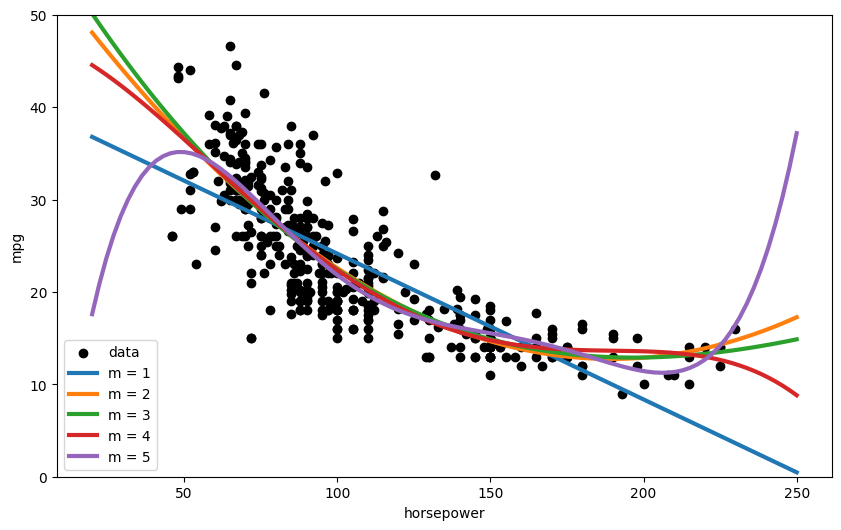

In [ ]:
lr = linear_model.LinearRegression() # create a linear regression object

# with scikit-learn, we have to extract values from the pandas dataframe
for m in np.arange(2,6): 
    auto['h'+str(m)] = auto['horsepower']**m

X = auto[['horsepower','h2','h3','h4','h5']].values.reshape(auto['horsepower'].shape[0],5)
y = auto['mpg'].values.reshape(auto['mpg'].shape[0],1)

plt.scatter(X[:,0], y,  color='black',label='data')

# make data for plotting
xs = np.linspace(20, 250, num=100)
Xs = np.zeros([100,5])
Xs[:,0] = xs
for m in np.arange(1,5): 
    Xs[:,m] = xs**(m+1)
    
for m in np.arange(1,6):     
    lr.fit(X=X[:,:m], y=y)
    plt.plot(xs, lr.predict(X=Xs[:,:m]), linewidth=3, label = "m = " + str(m) )

plt.legend()
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()

### Cross validation using scikit-learn 

- In scikit-learn, you can use the *train_test_split* function to split the dataset into a training dataset and a test dataset.
+ The *score* function returns the coefficient of determination, $R^2$, of the prediction.

In the following code, I've split the data in an unusual way - taking the test set to be 85% - to illustrate the point more clearly. 

(196, 5) (196, 1)
(196, 5) (196, 1)
m= 1 , train:  0.5911842631021547  test:  0.6171465759570592
m= 2 , train:  0.6568472219349888  test:  0.7090517592864355
m= 3 , train:  0.6569545399148506  test:  0.7097183187161527
m= 4 , train:  0.6574926089914337  test:  0.7111599023938853
m= 5 , train:  0.6654124617111528  test:  0.717142533105039


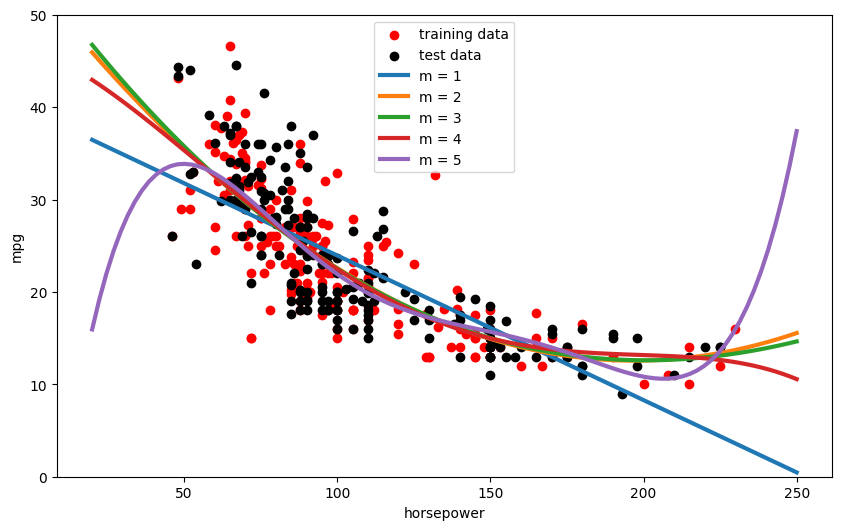

In [ ]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

plt.scatter(X_train[:,0], y_train,  color='red',label='training data')
plt.scatter(X_test[:,0], y_test,  color='black',label='test data')

for m in np.arange(1,6):     
    lr.fit(X=X_train[:,:m], y=y_train)
    print('m=', m, ', train: ', lr.score(X_train[:,:m], y_train), ' test: ', lr.score(X_test[:,:m], y_test))
    plt.plot(xs, lr.predict(X=Xs[:,:m]), linewidth=3, label = "m = " + str(m) )

plt.legend()
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()


/var/folders/p3/6fcprxgn0xb77hzb031vm1_m0000gn/T/ipykernel_22316/3976325191.py:22: RuntimeWarning: divide by zero encountered in reciprocal
  y5 = par5["Intercept"] + par5['horsepower']*x + par5['I(horsepower ** -1.0)']*x**-1
/var/folders/p3/6fcprxgn0xb77hzb031vm1_m0000gn/T/ipykernel_22316/3976325191.py:23: RuntimeWarning: divide by zero encountered in reciprocal
  y6 = par6["Intercept"] + par6['horsepower']*x + par6['I(horsepower ** -1.0)']*x**-1 + par6['I(horsepower ** -2.0)']*x**-2
/var/folders/p3/6fcprxgn0xb77hzb031vm1_m0000gn/T/ipykernel_22316/3976325191.py:23: RuntimeWarning: divide by zero encountered in power
  y6 = par6["Intercept"] + par6['horsepower']*x + par6['I(horsepower ** -1.0)']*x**-1 + par6['I(horsepower ** -2.0)']*x**-2
/var/folders/p3/6fcprxgn0xb77hzb031vm1_m0000gn/T/ipykernel_22316/3976325191.py:23: RuntimeWarning: invalid value encountered in add
  y6 = par6["Intercept"] + par6['horsepower']*x + par6['I(horsepower ** -1.0)']*x**-1 + par6['I(horsepower ** -2.0)']*x

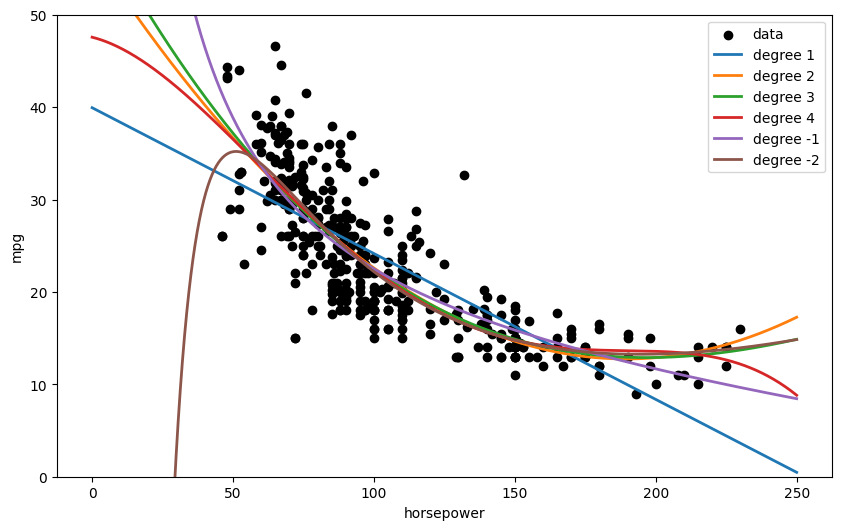

In [ ]:
# fit polynomial models
mr1 = sm.ols(formula="mpg ~ horsepower", data=auto).fit()
par1 = dict(mr1.params)
mr2 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** 2.0)", data=auto).fit()
par2 = dict(mr2.params)
mr3 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** 2.0) + I(horsepower ** 3.0)", data=auto).fit()
par3 = dict(mr3.params)
mr4 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** 2.0) + I(horsepower ** 3.0) + I(horsepower ** 4.0)", data=auto).fit()
par4 = dict(mr4.params)
mr5 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** -1.0)", data=auto).fit()
par5 = dict(mr5.params)
mr6 = sm.ols(formula="mpg ~ horsepower + I(horsepower ** -1.0) + I(horsepower ** -2.0)", data=auto).fit()
par6 = dict(mr6.params)

plt.scatter(auto['horsepower'],auto['mpg'],color='black',label="data")

x = np.linspace(0,250,1000)
y1 = par1["Intercept"] + par1['horsepower']*x
y2 = par2["Intercept"] + par2['horsepower']*x + par2['I(horsepower ** 2.0)']*x**2
y3 = par3["Intercept"] + par3['horsepower']*x + par3['I(horsepower ** 2.0)']*x**2 + par3['I(horsepower ** 3.0)']*x**3
y4 = par4["Intercept"] + par4['horsepower']*x + par4['I(horsepower ** 2.0)']*x**2 + par4['I(horsepower ** 3.0)']*x**3 + par4['I(horsepower ** 4.0)']*x**4
y5 = par5["Intercept"] + par5['horsepower']*x + par5['I(horsepower ** -1.0)']*x**-1
y6 = par6["Intercept"] + par6['horsepower']*x + par6['I(horsepower ** -1.0)']*x**-1 + par6['I(horsepower ** -2.0)']*x**-2

plt.plot(x,y1,label="degree 1",linewidth=2)
plt.plot(x,y2,label="degree 2",linewidth=2)
plt.plot(x,y3,label="degree 3",linewidth=2)
plt.plot(x,y4,label="degree 4",linewidth=2)
plt.plot(x,y5,label="degree -1",linewidth=2)
plt.plot(x,y6,label="degree -2",linewidth=2)

plt.legend()
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()

In [ ]:
mr5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     398.1
Date:                Tue, 28 May 2024   Prob (F-statistic):           7.83e-95
Time:                        09:59:55   Log-Likelihood:                -1142.8
No. Observations:                 392   AIC:                             2292.
Df Residuals:                     389   BIC:                             2304.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                11.4787      3.288      3.491      0.001       5.015      17.943
horsepower               -0.0354      0.015     -2.353      0.019      -0.065      -0.006
I(horsepower ** -1.0)  1456.0185    164.837      8.833      0.000    1131.935    1780.102
==============================================================================
Omnibus:                       16.639   Durbin-Watson:                   1.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.703
Skew:                           0.150   Prob(JB):                     1.07e-08
Kurtosis:                       4.469   Cond. No.                     8.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As the model complexity increases, 
- the accuracy on the training data increases, but 
+ the generalizability of the model to the test set decreases. 

Our job is to find a model that is sufficiently complex to describe the training data, but not so complex that it isn't generalizable to new data. 

## Class exercise: analysis of the credit dataset 

Next, let's use [Statsmodels](http://statsmodels.sourceforge.net/) to study a dataset related to credit cards.
We'll use the 'Credit' dataset, available 
[here](Credit.csv). 
This dataset consists of some credit card information for 400 people. 

Of course, a *credit card* is a card issued to a person ("cardholder"), typically from a bank, that can be used as a method of payment. The card allows the cardholder to borrow money from the bank to pay for goods and services. Credit cards have a *limit*, the maximum amount you can borrow, which is determined by the bank. The limit is determined from information collected from the cardholder (income, age, ...) and especially (as we will see) the cardholders "credit rating".  The *credit rating* is an evaluation of the (1) ability of the cardholder to pay back the borrowed money and (2) the likelihood of the cardholder to defaulting on the borrowed money. 

Our focus will be on the use of regression tools to study this dataset. Ideally, we'd like to understand what factors determine *credit ratings* and *credit limits*. We can think about this either from the point of view of (1) a bank who wants to protect their investments by minimizing credit defaults or (2) a person who is trying to increase their credit rating and/or credit limit. 

A difficulty we'll encounter is including categorical data in regression models.  

In [ ]:
# Import data from Credit.csv file
data_frame = pd.read_csv('Credit.csv')

In [ ]:
# Summarize and describe data
#dtypes, value_counts, describe
print(data_frame.dtypes)
print(data_frame.describe())
print(data_frame['Gender'].value_counts())
print(data_frame['Student'].value_counts())
print(data_frame['Married'].value_counts())
print(data_frame['Ethnicity'].value_counts())

Unnamed: 0      int64
Income        float64
Limit           int64
Rating          int64
Cards           int64
Age             int64
Education       int64
Gender         object
Student        object
Married        object
Ethnicity      object
Balance         int64
dtype: object
       Unnamed: 0      Income         Limit      Rating       Cards  \
count  400.000000  400.000000    400.000000  400.000000  400.000000   
mean   200.500000   45.218885   4735.600000  354.940000    2.957500   
std    115.614301   35.244273   2308.198848  154.724143    1.371275   
min      1.000000   10.354000    855.000000   93.000000    1.000000   
25%    100.750000   21.007250   3088.000000  247.250000    2.000000   
50%    200.500000   33.115500   4622.500000  344.000000    3.000000   
75%    300.250000   57.470750   5872.750000  437.250000    4.000000   
max    400.000000  186.634000  13913.000000  982.000000    9.000000   

              Age   Education      Balance  
count  400.000000  400.000000   400.0

The column names of this data are:  
1. Income 
+ Limit  
+ Rating  
+ Cards
+ Age  
+ Education  
+ Gender (categorial: M,F)
+ Student (categorial: Y,N)
+ Married (categorial: Y,N)
+ Ethnicity (categorial: Caucasian, Asian, African American) 
+ Balance

**Question:** What is wrong with the income data? How can it be fixed? 

The file 'Credit.csv' is a comma separated file. I assume a period was used instead of a comma to indicate thousands in income so it wouldn't get confused with the separating value? Or maybe this is a dataset from Europe? Or maybe the income is just measured in \$1k units?  To change the income data, we can use the Pandas series 'map' function. 


In [ ]:
# Fix income data.  originally in units of $1k
print(data_frame['Income'].head())

# Using pandas series map function to convert . to , instead
data_frame['Income'] = data_frame['Income'].map(lambda x: x * 1000)

0     14891.0
1    106025.0
2    104593.0
3    148924.0
4     55882.0
Name: Income, dtype: float64


In [ ]:
print(data_frame['Income'].head())
print(data_frame.describe())

0     14891000.0
1    106025000.0
2    104593000.0
3    148924000.0
4     55882000.0
Name: Income, dtype: float64
       Unnamed: 0        Income         Limit      Rating       Cards  \
count  400.000000  4.000000e+02    400.000000  400.000000  400.000000   
mean   200.500000  4.521888e+07   4735.600000  354.940000    2.957500   
std    115.614301  3.524427e+07   2308.198848  154.724143    1.371275   
min      1.000000  1.035400e+07    855.000000   93.000000    1.000000   
25%    100.750000  2.100725e+07   3088.000000  247.250000    2.000000   
50%    200.500000  3.311550e+07   4622.500000  344.000000    3.000000   
75%    300.250000  5.747075e+07   5872.750000  437.250000    4.000000   
max    400.000000  1.866340e+08  13913.000000  982.000000    9.000000   

              Age   Education      Balance  
count  400.000000  400.000000   400.000000  
mean    55.667500   13.450000   520.015000  
std     17.249807    3.125207   459.758877  
min     23.000000    5.000000     0.000000  
25%

We can also look at the covariances in the data. (This is how the variables vary together.) There are two ways to do this:
1. Quantitatively: Compute the correlation matrix. For each pair of variables, $(x_i,y_i)$, we compute 
$$
\frac{\sum_i (x_i - \bar x) (y_i - \bar y)}{s_x s_y}
$$ 
where $\bar x, \bar y$ are sample means and $s_x, s_y$ are sample variances. 
+ Visually: Make a scatter matrix of the data


In [ ]:
# use the corr method to compute the correlation matrix

# all values in df must be in numerical value to compute matrix
data_frame = pd.get_dummies(data_frame, columns=['Gender', 'Student', 'Married', 'Ethnicity'], drop_first=True)
correlation_matrix = data_frame.corr()

print(correlation_matrix)

                     Unnamed: 0    Income     Limit    Rating     Cards  \
Unnamed: 0             1.000000  0.037203  0.024172  0.021985 -0.036304   
Income                 0.037203  1.000000  0.792088  0.791378 -0.018273   
Limit                  0.024172  0.792088  1.000000  0.996880  0.010231   
Rating                 0.021985  0.791378  0.996880  1.000000  0.053239   
Cards                 -0.036304 -0.018273  0.010231  0.053239  1.000000   
Age                    0.058603  0.175338  0.100888  0.103165  0.042948   
Education             -0.001415 -0.027692 -0.023549 -0.030136 -0.051084   
Balance                0.006064  0.463656  0.861697  0.863625  0.086456   
Gender_Female         -0.118177 -0.010738  0.009397  0.008885 -0.022658   
Student_Yes           -0.040342  0.019632 -0.006015 -0.002028 -0.026164   
Married_Yes            0.022465  0.035652  0.031155  0.036751 -0.009695   
Ethnicity_Asian       -0.060254 -0.017137 -0.032427 -0.035999  0.005591   
Ethnicity_Caucasian    0.

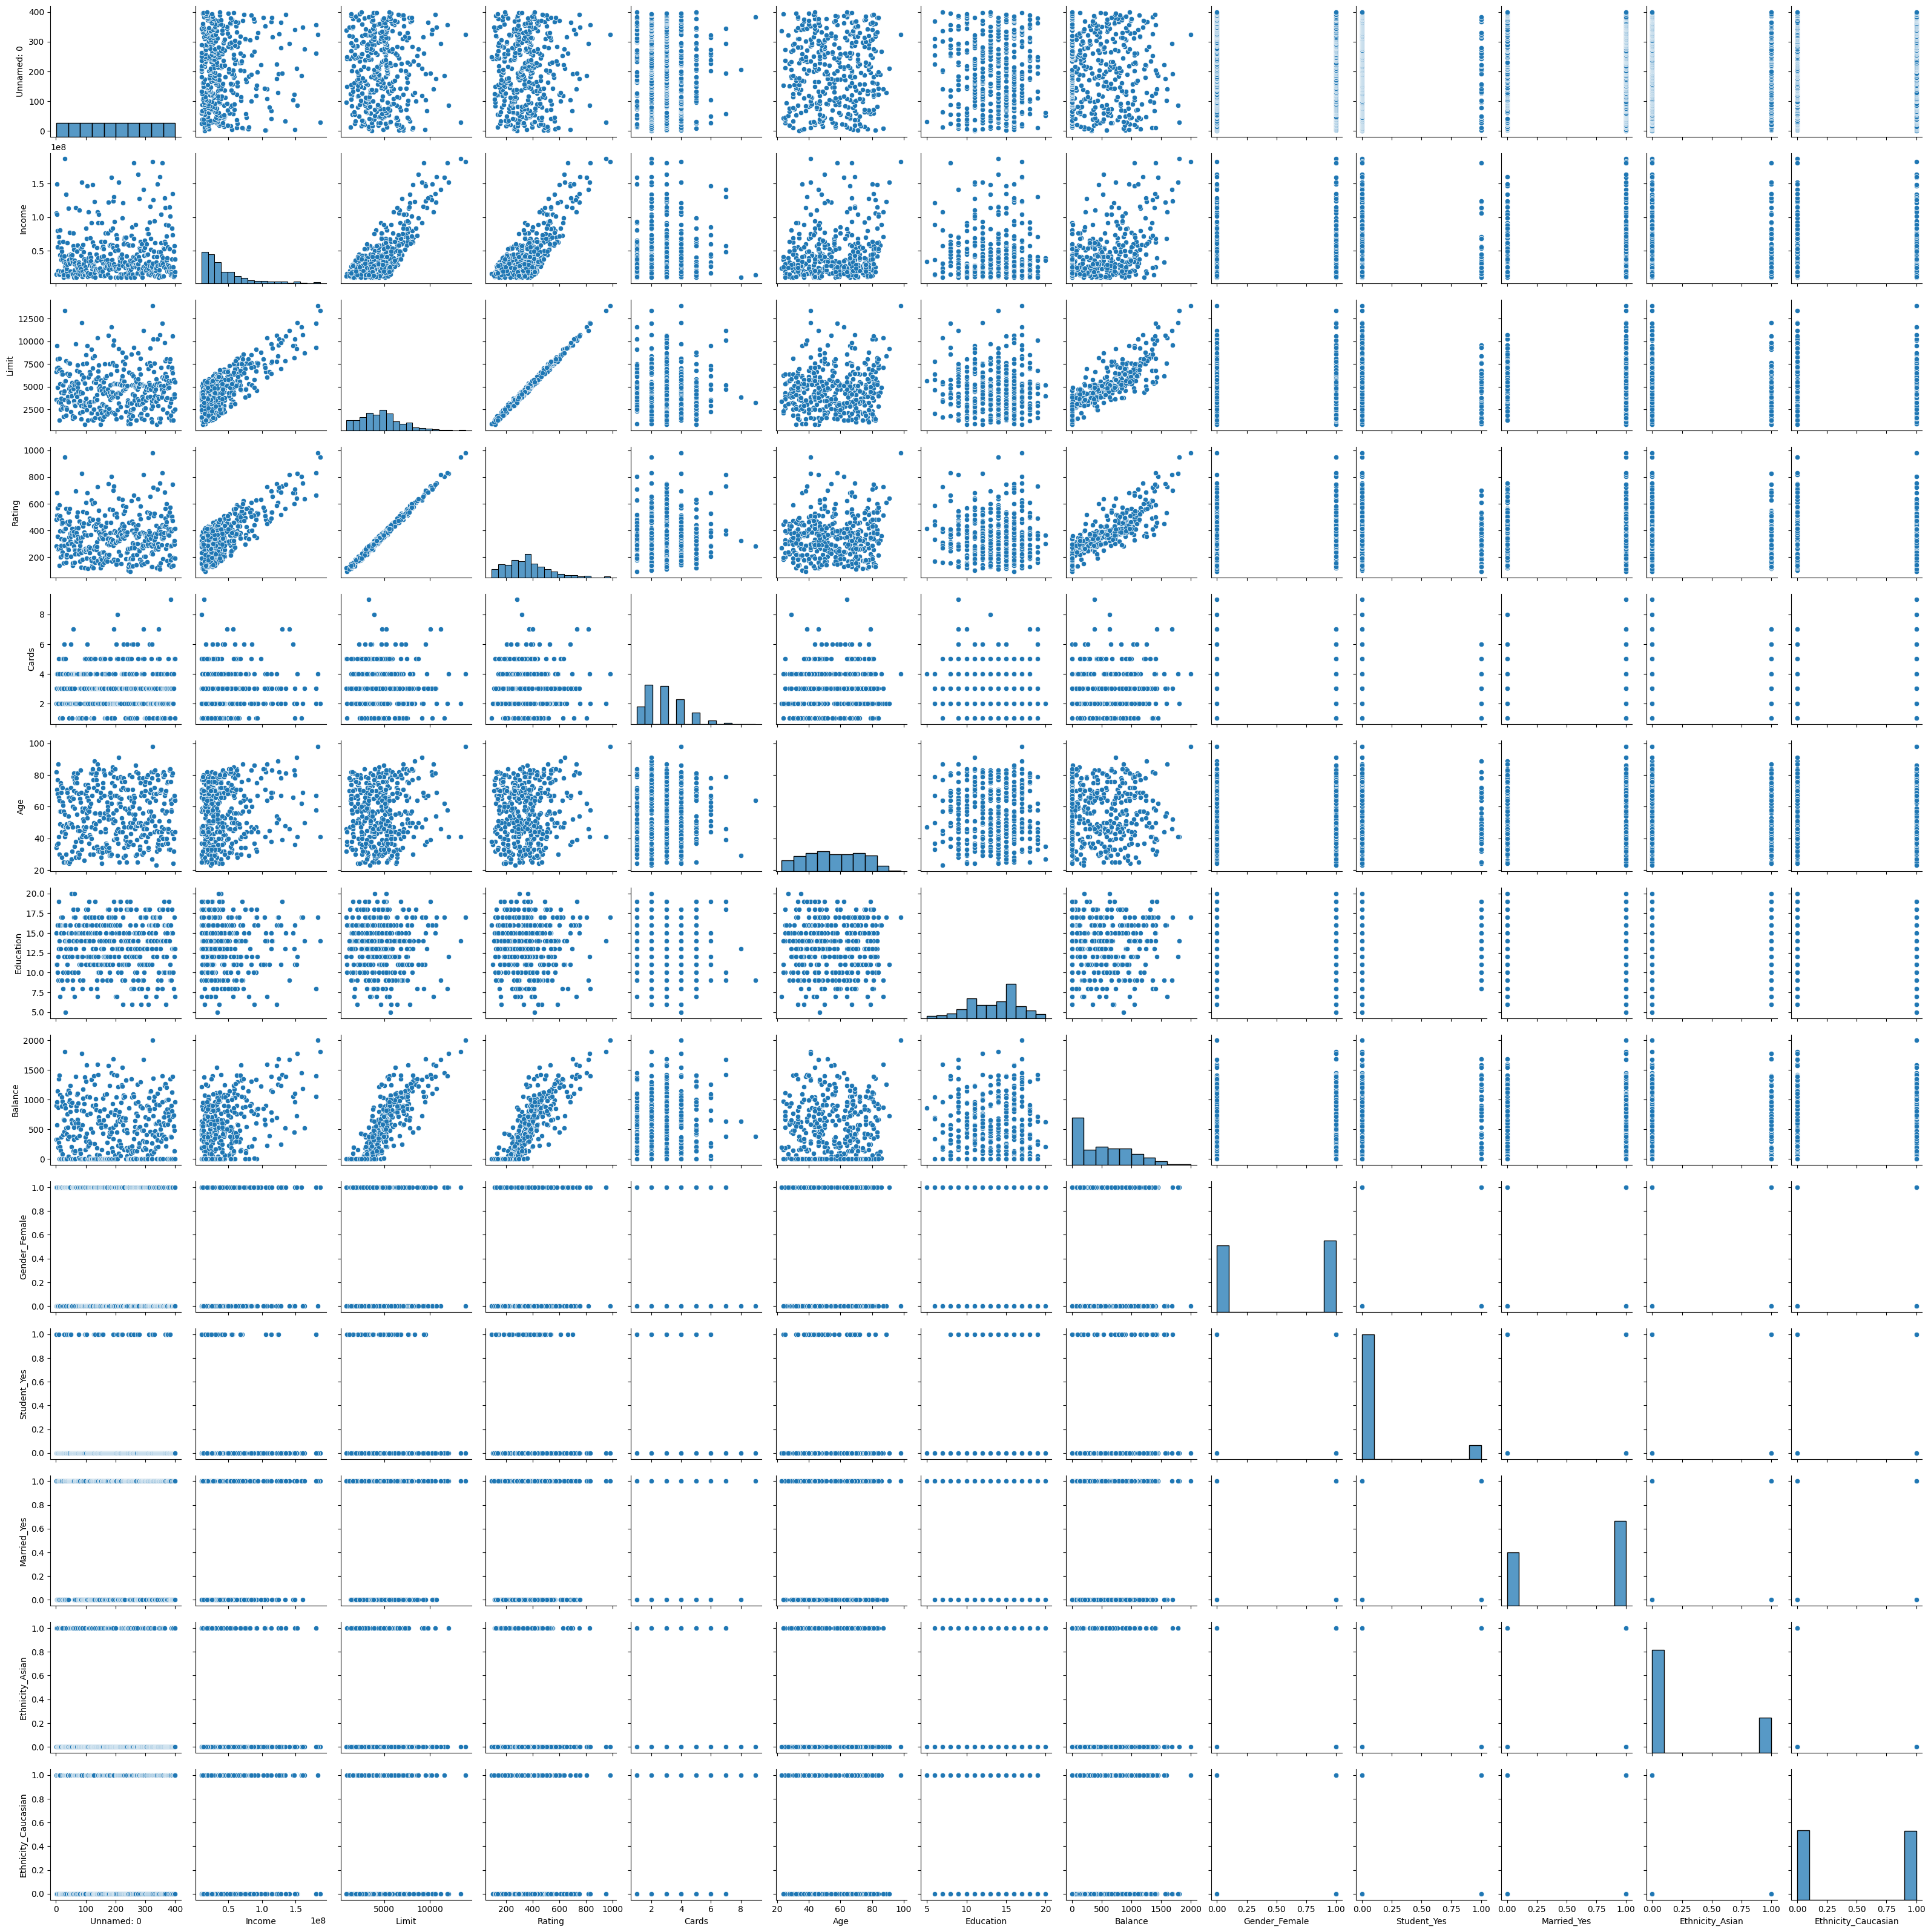

In [ ]:
import seaborn as sns
# use the scatter_matrix function
sns.pairplot(data_frame)
plt.show()

**Observations:**
1. Limit and Rating are highly correlated ($99.7\%$)  
+ Income strongly correlates with Limit ($79\%$) and Rating ($79\%$)
+ Balance correlates with Limit ($86\%$) and Rating ($86\%$)
+ There are "weird stripes" in some of the data. Why? 
+ Categorical information doesn't appear in this plot. Why? How can I visualize the categorical variables?

Answers:
- Strong linear relationship. Directly proportional to each other.
- Income strongly related to limit and rating which suggests higher income leads to higher credit limit and better credit ratings.
- Weird stripes in scatter plot could be discrete values within data.
- Correlation matrix only includes numerical variables. To visualize categorical variables, we need other approaches such as box plots, bar plots and some scatter plots.

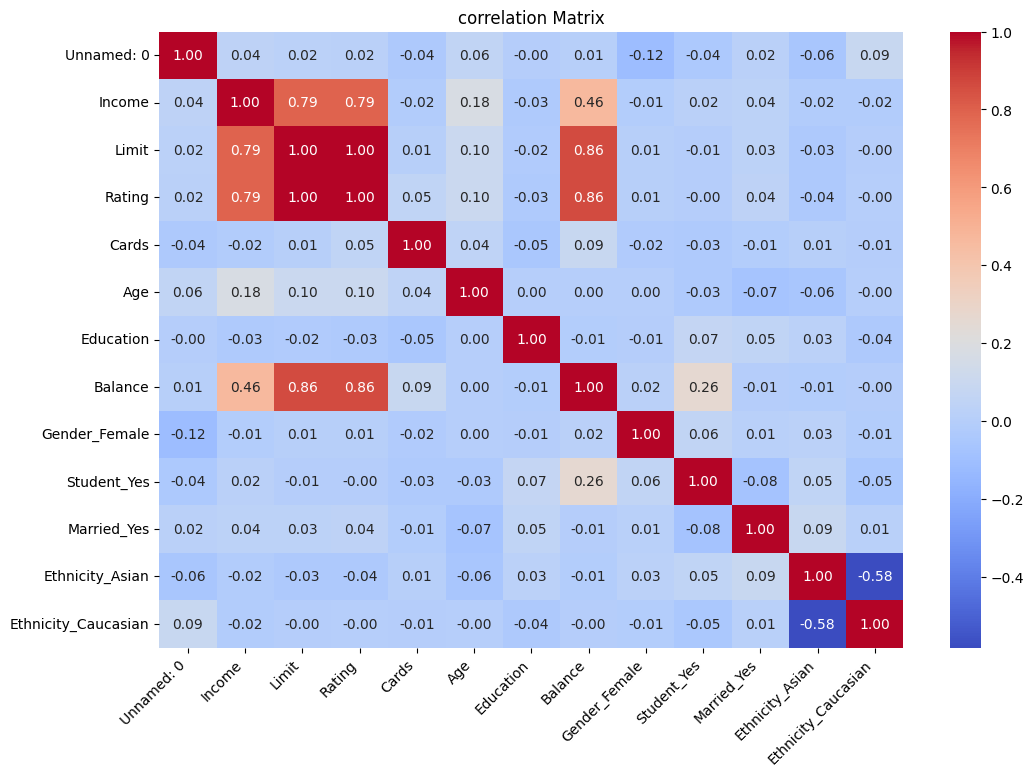

In [ ]:
# Plot Categorical variables: Gender, Student, Married, Ethnicity
# heat map for corr matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

## A first regression model

**Exercise** First regress Limit on Rating: 
$$
\text{Limit} = \beta_0 + \beta_1 \text{Rating}. 
$$
Since credit ratings are primiarily used by banks to determine credit limits, we expect that Rating is very predictive for Limit, so this regression should be very good. 

Use the 'ols' function from the statsmodels python library. 


In [ ]:
# Use statsmodels for a basic OLS

# Limit is dependent y value and x is Rating indepedent variable
model = sm.ols('Limit ~ Rating', data=data_frame).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Limit   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 6.348e+04
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        17:46:38   Log-Likelihood:                -2649.1
No. Observations:                 400   AIC:                             5302.
Df Residuals:                     398   BIC:                             5310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -542.9282     22.850    -23.760      0.0

$credit limit = 14.8*rating - 542$

## Predicting limit without rating 

Since Rating and Limit are almost the same variable, next we'll forget about Limit and just try to predict Rating from the real-valued variables (non-categorical variables): Income, Cards, Age, Education, Balance. 

**Exercise:** Develop a multilinear regression model to predict Rating. 
Interpret the results. 

For now, just focus on the real-valued variables (Income, Cards, Age, Education, Balance)
and ignore the categorial variables (Gender, Student, Married, Ethnicity). 



In [ ]:
model = sm.ols('Rating ~ Income + Cards + Age + Education + Balance', data=data_frame).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1255.
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.68e-239
Time:                        18:18:29   Log-Likelihood:                -2017.9
No. Observations:                 400   AIC:                             4048.
Df Residuals:                     394   BIC:                             4072.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    143.6089     11.377     12.622      0.0

Which independent variables are good/bad predictors? 

**Observations:**
1. Income and balance are best predictors
+ Including other variables (Cards, Age, Education) doesn't increase $R^2$ by much. 

## Incorporating categorical variables into regression models

We have four categorical variables (Gender, Student, Married, Ethnicity). How can we include them in a regression model? 

Let's start with a categorical variable with only 2 categories: Gender (Male, Female).

Idea: Create a "dummy variable" that turns Gender into a real value: 
$$
\text{GenderNum}_i = \begin{cases} 
1 & \text{if $i$-th person is female} \\
0 & \text{if $i$-th person is male}
\end{cases}. 
$$
Then we could try to fit a model of the form
$$
\text{Income} = \beta_0 + \beta_1 \text{GenderNum}. 
$$

In [ ]:
#use map
data_frame['GenderNum'] = data_frame['Gender'].map({'Female':1, 'Male':0})

# regression model income = b0 + b1GenderNum
model = sm.ols('Income ~ GenderNum', data = data_frame).fit()

# prints summary of regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 28 May 2024   Prob (F-statistic):                nan
Time:                        19:01:12   Log-Likelihood:                -1028.9
No. Observations:                 207   AIC:                             2060.
Df Residuals:                     206   BIC:                             2063.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.4270      1.215     18.462      0.0

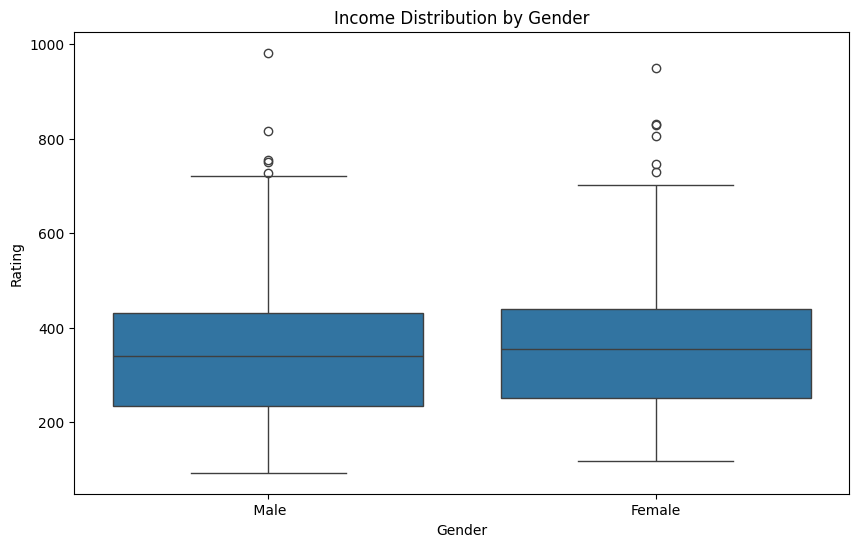

In [ ]:
# plot credit scores for the various genders
plt.figure(figsize=(10, 6))
sns.boxplot(x='GenderNum', y ='Rating', data=data_frame)
plt.title('Income Distribution by Gender')
plt.show()



Since the $p$-value for the Gender_num coefficient is very large, there is no support for the conclusion that there is a difference in credit card balance between genders.

**Exercise**: Try to find a meaningful relationship in the data including one of the categorical variables (Gender, Student, Married), for example, Balance vs. Student, Credit vs. Married, etc... 


In [50]:
#use corr
# transform non numeral values into numerical values
data_frame['StudentNum'] = data_frame['Student'].map({'Yes':1, 'No':0})
data_frame['MarriedNum'] = data_frame['Married'].map({'Yes':1, 'No':0})

model = sm.ols('Balance ~ MarriedNum', data = data_frame).fit()
# print(model.summary())

numeric_cols = data_frame.select_dtypes(include=[float, int])

correlation_matrix = numeric_cols.corr()
balance_corr = correlation_matrix['Income']
print(balance_corr)


Unnamed: 0    0.037203
Income        1.000000
Limit         0.792088
Rating        0.791378
Cards        -0.018273
Age           0.175338
Education    -0.027692
Balance       0.463656
GenderNum          NaN
StudentNum    0.019632
MarriedNum    0.035652
Name: Income, dtype: float64


## What about a categorical variable with 3 categories? 

The Ethnicity variable takes three values: Caucasian, Asian, and African American. 

What's wrong with the following?  
$$
\text{EthnicityNum}_i = \begin{cases} 
0 & \text{if $i$-th person is Caucasian} \\
1 & \text{if $i$-th person is Asian} \\ 
2 & \text{if $i$-th person is African American}
\end{cases}. 
$$

Hint: Recall Nominal, Ordinal, Interval, Ratio variable types from Lecture 4 (Descriptive Statistics).

We'll need more than one dummy variable:  
$$
\text{Asian}_i = \begin{cases} 
1 & \text{if $i$-th person is Asian} \\
0 & \text{otherwise}
\end{cases}. 
$$
$$
\text{Caucasian}_i = \begin{cases} 
1 & \text{if $i$-th person is Caucasian} \\
0 & \text{otherwise}
\end{cases}. 
$$
The value with no dummy variable--African American--is called the *baseline*.

We can use the *get_dummies* function to automatically get these values

In [51]:
#get dummies


**Exercise**: Can you find a relationship in the data involving the variable ethnicity? 

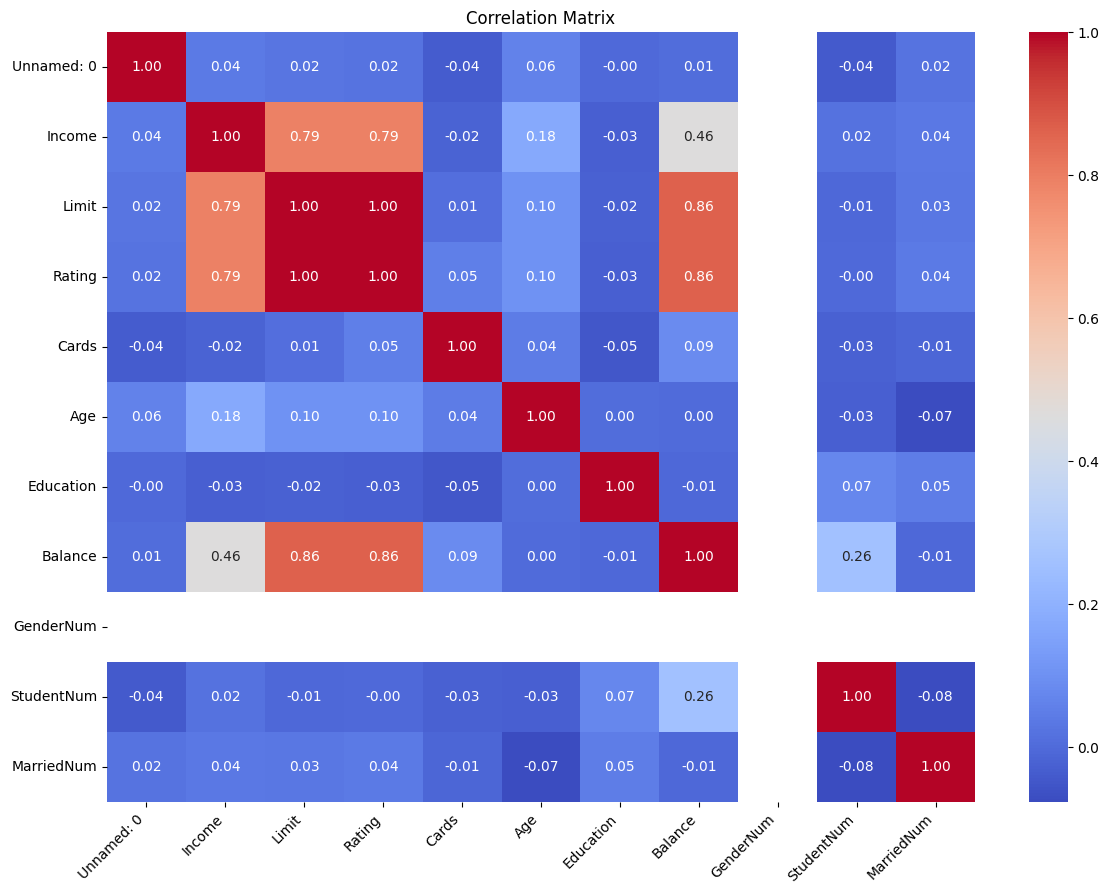

In [53]:
# your code here 
plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()